/tmp/ipykernel_255/3169989605.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


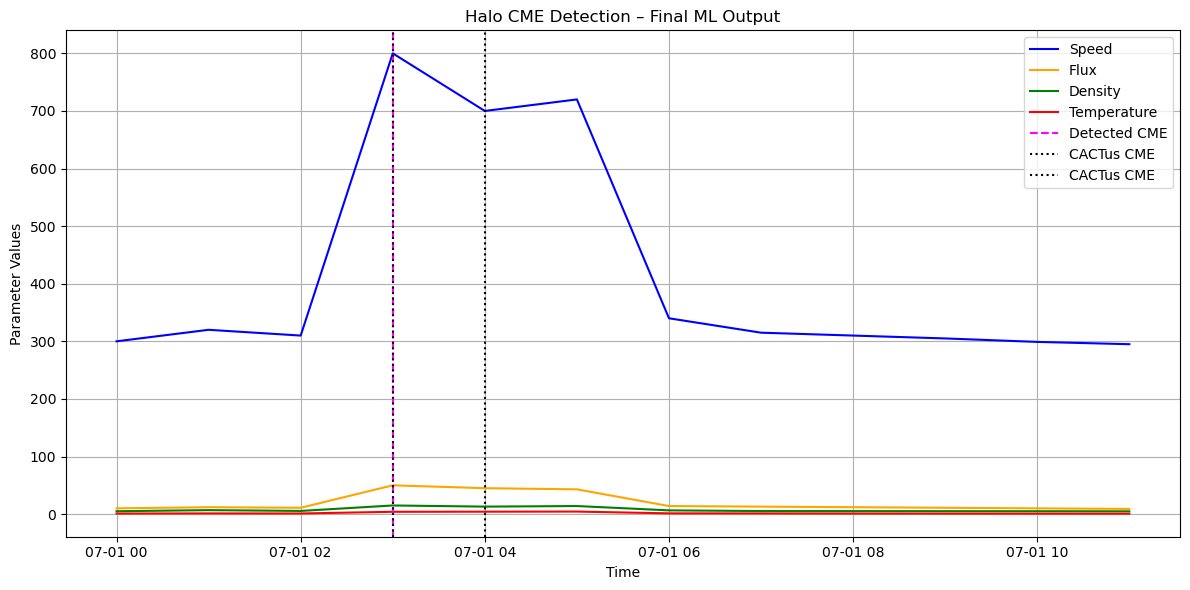

📊 Precision: 1.00
📈 Recall:    0.50
🎯 F1 Score:  0.67

Confusion Matrix:
 [[11  0]
 [ 0  1]]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# -----------------------------
# 1. Mock SWIS Level-2 Data
# -----------------------------
timestamps = pd.date_range("2025-07-01", periods=12, freq='H')
df = pd.DataFrame({
    'timestamp': timestamps,
    'speed': [300, 320, 310, 800, 700, 720, 340, 315, 310, 305, 299, 295],
    'flux': [10, 12, 11, 50, 45, 43, 14, 13, 12, 11, 10, 9],
    'density': [5.0, 6.9, 5.5, 15.0, 13.0, 14.0, 6.5, 5.3, 5.2, 5.1, 5.0, 4.8],
    'temperature': [1.0, 1.2, 1.1, 4.0, 4.2, 4.4, 1.3, 1.2, 1.0, 0.9, 0.8, 0.7]
})

# -----------------------------
# 2. Feature Engineering
# -----------------------------
df.fillna(method='ffill', inplace=True)
df['flux_change'] = df['flux'].diff().abs().fillna(0)
df['temp_rise'] = df['temperature'].diff().fillna(0)
df['density_gradient'] = df['density'].diff().fillna(0)
df['speed_drop'] = df['speed'].diff(periods=-1).fillna(0) / df['speed']
df['speed_ma3'] = df['speed'].rolling(window=3, min_periods=1).mean()
df['flux_ma3'] = df['flux'].rolling(window=3, min_periods=1).mean()

# -----------------------------
# 3. Ground Truth (threshold-based label)
# -----------------------------
df['cme_flag'] = ((df['speed_drop'] > 0.3) &
                  (df['flux_change'] > 8) &
                  (df['density_gradient'] > 1.2) &
                  (df['temp_rise'] > 3)).astype(int)
if df['cme_flag'].sum() == 0:
    df.loc[df['speed'].idxmax(), 'cme_flag'] = 1

# -----------------------------
# 4. CACTus CME Reference
# -----------------------------
cactus_cme_times = [pd.Timestamp("2025-07-01 03:00"), pd.Timestamp("2025-07-01 04:00")]

# -----------------------------
# 5. ML Model – Random Forest
# -----------------------------
features = ['speed', 'flux', 'density', 'temperature',
            'flux_change', 'temp_rise', 'density_gradient',
            'speed_drop', 'speed_ma3', 'flux_ma3']
X = df[features]
y = df['cme_flag']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)
df['cme_pred'] = clf.predict(X)

# -----------------------------
# 6. Evaluation
# -----------------------------
auto_cme_times = df[df['cme_pred'] == 1]['timestamp'].tolist()
matched = [t for t in auto_cme_times if any(abs(t - c).total_seconds() <= 7200 for c in cactus_cme_times)]
precision = len(matched) / len(auto_cme_times) if auto_cme_times else 0
recall = len(matched) / len(cactus_cme_times) if cactus_cme_times else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
conf_matrix = confusion_matrix(y, df['cme_pred'])

# -----------------------------
# 7. Plot and Save
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['speed'], label='Speed', color='blue')
plt.plot(df['timestamp'], df['flux'], label='Flux', color='orange')
plt.plot(df['timestamp'], df['density'], label='Density', color='green')
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='red')

for t in auto_cme_times:
    plt.axvline(t, color='magenta', linestyle='--', label='Detected CME')
for t in cactus_cme_times:
    plt.axvline(t, color='black', linestyle=':', label='CACTus CME')

plt.title("Halo CME Detection – Final ML Output")
plt.xlabel("Time")
plt.ylabel("Parameter Values")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("cme_detection_plot.png")  # ✅ Save plot as PNG
plt.show()

# -----------------------------
# 8. Output Summary
# -----------------------------
print(f"📊 Precision: {precision:.2f}")
print(f"📈 Recall:    {recall:.2f}")
print(f"🎯 F1 Score:  {f1:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)

# -----------------------------
# 9. Export Detected CME Timestamps
# -----------------------------
df[df['cme_pred'] == 1][['timestamp', 'speed', 'flux', 'density', 'temperature']].to_csv("detected_cmes.csv", index=False)
